In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import math
import warnings

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# TODO: Use python PathLib to use 
DATA_PATH = '../data/'

In [3]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

In [4]:
def test_stationarity(timeseries, cutoff = 0.01):
    
    print('Results of Dickey-Fuller Test:')
#     dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

    
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
  # prepare training dataset
  train_size = int(len(X) * 0.66)
  train, test = X[0:train_size], X[train_size:]
  history = [x for x in train]
  # make predictions
  predictions = list()
  for t in range(len(test)):
    model = ARIMA(history, order=arima_order)
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])
  # calculate out of sample error
  rmse = sqrt(mean_squared_error(test, predictions))
  return rmse


def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
         for q in q_values:
           order = (p,d,q)
           try:
             rmse = evaluate_arima_model(dataset, order)
             if rmse < best_score:
                best_score, best_cfg = rmse, order 
                print('ARIMA%s RMSE=%.3f' % (order,rmse))
           except:
             continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [25]:
y_train_pm25 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm25_train_test/y_train_pm25.feather')
y_train_pm10 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm10_train_test/y_train_pm10.feather')


y_train_pm25 = y_train_pm25.set_index('utc_datetime')
y_train_pm25[y_train_pm25['PM2.5'] == -1] = np.nan # It was set to -1 so it could work with XGBoost

y_train_pm10 = y_train_pm10.set_index('utc_datetime')
y_train_pm10[y_train_pm10['PM10'] == -1] = np.nan # It was set to -1 so it could work with XGBoost

## Test stationarity

In [6]:
test_stationarity(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()], 0.05)

Results of Dickey-Fuller Test:
p-value = 0.000000. The series is likely stationary.
Test Statistic                -1.144424e+01
p-value                        6.073249e-21
#Lags Used                     1.500000e+01
Number of Observations Used    6.680000e+03
Critical Value (1%)           -3.431329e+00
Critical Value (5%)           -2.861973e+00
Critical Value (10%)          -2.567000e+00
dtype: float64


In [26]:
test_stationarity(y_train_pm10['PM10'][y_train_pm10['PM10'].notnull()], 0.05)

Results of Dickey-Fuller Test:
p-value = 0.000000. The series is likely stationary.
Test Statistic                -8.194530e+00
p-value                        7.511278e-13
#Lags Used                     2.900000e+01
Number of Observations Used    3.893000e+03
Critical Value (1%)           -3.432031e+00
Critical Value (5%)           -2.862283e+00
Critical Value (10%)          -2.567165e+00
dtype: float64


## Check correlation with lagged versions of PM2.5

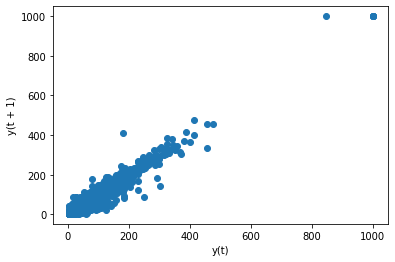

In [7]:
lag_plot(y_train_pm25['PM2.5'])

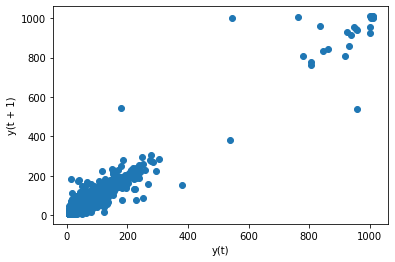

In [28]:
lag_plot(y_train_pm10['PM10'])

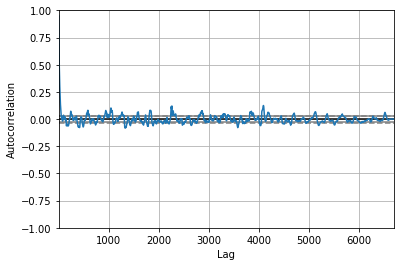

In [8]:
autocorrelation_plot(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

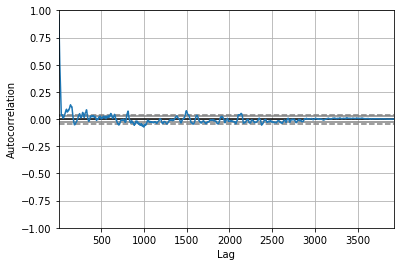

In [29]:
autocorrelation_plot(y_train_pm10['PM10'][y_train_pm10['PM10'].notnull()])

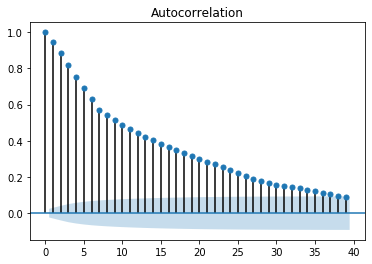

In [30]:
x = plot_acf(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

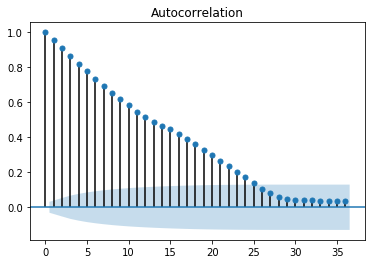

In [32]:
x = plot_acf(y_train_pm10['PM10'][y_train_pm10['PM10'].notnull()])

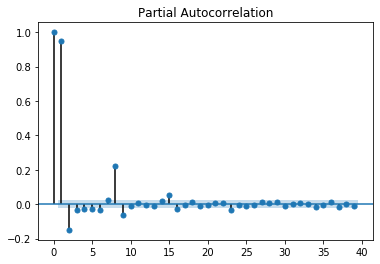

In [10]:
x = plot_pacf(y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()])

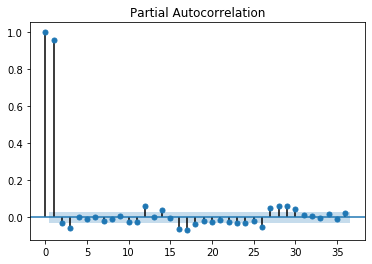

In [34]:
x = plot_pacf(y_train_pm10['PM10'][y_train_pm10['PM10'].notnull()])

## ARIMA

### ARIMA PM2.5

In [50]:
# Use AR(3) as parameters based on acf and pacf

/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                  PM2.5   No. Observations:                 6696
Model:                     ARMA(3, 0)   Log Likelihood              -29225.805
Method:                       css-mle   S.D. of innovations             19.021
Date:                Sat, 05 Oct 2019   AIC                          58461.609
Time:                        11:54:33   BIC                          58495.655
Sample:                             0   HQIC                         58473.367
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          54.0049      3.784     14.271      0.000      46.588      61.422
ar.L1.PM2.5     1.0856      0.012     88.855      0.000       1.062       1.110
ar.L2.PM2.5    -0.1147      0.018     -6.380    

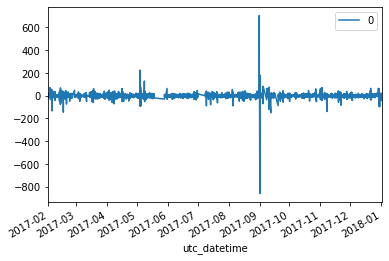

In [41]:
nonnull_pm25_y_train = y_train_pm25['PM2.5'][y_train_pm25['PM2.5'].notnull()]
pm25_model = ARIMA(nonnull_pm25_y_train, order=(3,0,0))
model_fit_pm25 = pm25_model.fit(disp=0)
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals_pm25 = pd.DataFrame(model_fit_pm25.resid) 
residuals_pm25.plot()
# density plot of residuals residuals.plot(kind='kde') pyplot.show()
# summary stats of residuals
print(residuals_pm25.describe())

In [37]:
y_valid_pm25 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm25_train_test/y_valid_pm25.feather')
y_valid_pm25 = y_valid_pm25.set_index('utc_datetime')
y_valid_pm25.shape

(2016, 1)

In [36]:
forecast_result = model_fit_pm25.forecast(steps=2016)

In [38]:
nonnull_values = y_valid_pm25['PM2.5'].notnull()
y = y_valid_pm25['PM2.5'][nonnull_values]
predictions = forecast_result[0]
predictions = predictions[nonnull_values]
rmse(predictions, y)

64.65844776110765

### ARIMA PM10

/Users/mjjim2003/Documents/Eskwelabs/Capstone_Project/Air_Quality/KDD_Air_Quality/kdd_air_quality/env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                   PM10   No. Observations:                 3923
Model:                     ARMA(2, 0)   Log Likelihood              -18085.699
Method:                       css-mle   S.D. of innovations             24.311
Date:                Sat, 05 Oct 2019   AIC                          36179.397
Time:                        11:55:23   BIC                          36204.496
Sample:                             0   HQIC                         36188.303
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.2634      8.499      7.326      0.000      45.605      78.922
ar.L1.PM10     0.9839      0.016     61.663      0.000       0.953       1.015
ar.L2.PM10    -0.0293      0.016     -1.835      0.0

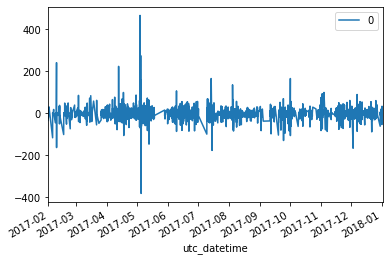

In [42]:
nonnull_pm10_y_train = y_train_pm10['PM10'][y_train_pm10['PM10'].notnull()]
pm10_model = ARIMA(nonnull_pm10_y_train, order=(2,0,0))
model_fit_pm10 = pm10_model.fit(disp=0)
# summary of fit model
print(model_fit_pm10.summary())
# line plot of residuals
residuals_pm10 = pd.DataFrame(model_fit_pm10.resid) 
residuals_pm10.plot()
# density plot of residuals residuals.plot(kind='kde') pyplot.show()
# summary stats of residuals
print(residuals_pm10.describe())

In [43]:
y_valid_pm10 = pd.read_feather(DATA_PATH + 'processed/donggaocun/pm10_train_test/y_valid_pm10.feather')
y_valid_pm10 = y_valid_pm10.set_index('utc_datetime')
y_valid_pm10.shape

(2016, 1)

In [44]:
forecast_result_pm10 = model_fit_pm10.forecast(steps=2016)

In [45]:
nonnull_values_pm10 = y_valid_pm10['PM10'].notnull()
y_pm10 = y_valid_pm10['PM10'][nonnull_values_pm10]
predictions_pm10 = forecast_result[0]
predictions_pm10 = predictions[nonnull_values]
rmse(predictions_pm10, y_pm10)

49.9582197077799

## ARIMA with imputation

In [16]:
y_train_pm25.shape

(8062, 1)

In [47]:
from fancyimpute import SoftImpute, KNN, BiScaler

imputed_pm25_train = SoftImpute().fit_transform(y_train_pm25)
model_imputed = ARIMA(imputed_pm25_train, order=(3,0,0))
model_fit_imputed = model_imputed.fit(disp=0)

forecast_result_imputed = model_fit_imputed.forecast(steps=2016)

nonnull_values = y_valid_pm25['PM2.5'].notnull()
y = y_valid_pm25['PM2.5'][nonnull_values]
predictions = forecast_result_imputed[0]
predictions = predictions[nonnull_values]
rmse(predictions, y)

[SoftImpute] Max Singular Value of X_init = 6654.296356
[SoftImpute] Iter 1: observed MAE=1.082157 rank=1
[SoftImpute] Iter 2: observed MAE=1.082157 rank=1
[SoftImpute] Iter 3: observed MAE=1.082157 rank=1
[SoftImpute] Iter 4: observed MAE=1.082157 rank=1
[SoftImpute] Iter 5: observed MAE=1.082157 rank=1
[SoftImpute] Iter 6: observed MAE=1.082157 rank=1
[SoftImpute] Iter 7: observed MAE=1.082157 rank=1
[SoftImpute] Iter 8: observed MAE=1.082157 rank=1
[SoftImpute] Iter 9: observed MAE=1.082157 rank=1
[SoftImpute] Iter 10: observed MAE=1.082157 rank=1
[SoftImpute] Iter 11: observed MAE=1.082157 rank=1
[SoftImpute] Iter 12: observed MAE=1.082157 rank=1
[SoftImpute] Iter 13: observed MAE=1.082157 rank=1
[SoftImpute] Iter 14: observed MAE=1.082157 rank=1
[SoftImpute] Iter 15: observed MAE=1.082157 rank=1
[SoftImpute] Iter 16: observed MAE=1.082157 rank=1
[SoftImpute] Iter 17: observed MAE=1.082157 rank=1
[SoftImpute] Iter 18: observed MAE=1.082157 rank=1
[SoftImpute] Iter 19: observed MAE=

66.10281489329252

In [49]:
imputed_pm10_train = SoftImpute().fit_transform(y_train_pm10)
model_imputed_pm10 = ARIMA(imputed_pm10_train, order=(2,0,0))
model_fit_imputed_pm10 = model_imputed_pm10.fit(disp=0)

forecast_result_imputed_pm10 = model_fit_imputed_pm10.forecast(steps=2016)

nonnull_values_pm10 = y_valid_pm10['PM10'].notnull()
y = y_valid_pm10['PM10'][nonnull_values_pm10]
predictions_pm10 = forecast_result_imputed_pm10[0]
predictions_pm10 = predictions_pm10[nonnull_values]
rmse(predictions_pm10, y)

[SoftImpute] Max Singular Value of X_init = 6502.824079
[SoftImpute] Iter 1: observed MAE=1.248264 rank=1
[SoftImpute] Iter 2: observed MAE=1.248264 rank=1
[SoftImpute] Iter 3: observed MAE=1.248264 rank=1
[SoftImpute] Iter 4: observed MAE=1.248264 rank=1
[SoftImpute] Iter 5: observed MAE=1.248264 rank=1
[SoftImpute] Iter 6: observed MAE=1.248264 rank=1
[SoftImpute] Iter 7: observed MAE=1.248264 rank=1
[SoftImpute] Iter 8: observed MAE=1.248264 rank=1
[SoftImpute] Iter 9: observed MAE=1.248264 rank=1
[SoftImpute] Iter 10: observed MAE=1.248264 rank=1
[SoftImpute] Iter 11: observed MAE=1.248264 rank=1
[SoftImpute] Iter 12: observed MAE=1.248264 rank=1
[SoftImpute] Iter 13: observed MAE=1.248264 rank=1
[SoftImpute] Iter 14: observed MAE=1.248264 rank=1
[SoftImpute] Iter 15: observed MAE=1.248264 rank=1
[SoftImpute] Iter 16: observed MAE=1.248264 rank=1
[SoftImpute] Iter 17: observed MAE=1.248264 rank=1
[SoftImpute] Iter 18: observed MAE=1.248264 rank=1
[SoftImpute] Iter 19: observed MAE=

44.34044138822746

## Grid Search ARIMA

In [ ]:
# evaluate parameters
# p_values = [0, 1, 2]
# d_values = range(0, 3)
# q_values = range(0, 3)
# warnings.filterwarnings("ignore")
# evaluate_models(nonnull_pm25_y_train, p_values, d_values, q_values)